In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from utils.distributions import marchenko_pastur_svals

In [2]:
data_dir = "data"
plot_dir = "plots"

In [3]:
def plot_layer_svals(layer: str, m: int, n: int):
    fig, axs = plt.subplots(3, 4, figsize = (12, 8))

    svals_df = pd.read_csv(f"{data_dir}/svals/{layer}.csv")

    fig.suptitle(f"{layer} weights singular values distributions")
    for i in range(12):
        # retrieving block specific data
        sigma = svals_df.iloc[0,i+1]
        svals = svals_df.iloc[1:,i+1].to_numpy()

        # marchenko-pastur distribution
        x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
        # the first element is removed because if 0 it leads to division error
        if (x_mp[0] < 1e-6):
            x_mp = x_mp[1:]
        y_mp, _, _ = marchenko_pastur_svals(x_mp, sigma, m, n)
        y_mp = y_mp / torch.trapezoid(y_mp, x_mp)

        # plotting
        ax = axs[i//4, i%4]
        ax.hist(svals, bins = "fd", density = True)
        mp_plot, = ax.plot(x_mp, y_mp, color = "r", linestyle = "--")
        ax.set_title(f"block {i}")
        ax.set_xlim(0,x_mp[-1])
    
    # labels
    for ax in axs[2,:]: ax.set_xlabel(r"$s$")
    for ax in axs[:,0]: ax.set_ylabel("density")

    # legend
    mp_plot.set_label("MP distribution")
    fig.legend()

    fig.tight_layout()
    plt.savefig(f"{plot_dir}/svals/{layer}.pdf")

    return

In [7]:
def plot_layer_overlaps(layer: str, m: int, n: int):
    fig, axs = plt.subplots(3, 4, figsize = (12, 8))

    svals_df = pd.read_csv(f"{data_dir}/svals/{layer}.csv")
    overlaps_df = pd.read_csv(f"{data_dir}/overlaps/{layer}.csv")

    fig.suptitle(f"{layer} overlaps")
    for i in range(12):
        # retrieving block specific data
        sigma = svals_df.iloc[0,i+1]
        svals = svals_df.iloc[1:,i+1].to_numpy()
        overlaps = overlaps_df.iloc[:,i+1].to_numpy()

        # marchenko-pastur distribution
        x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
        # the first element is removed because if 0 it leads to division error
        if (x_mp[0] < 1e-6):
            x_mp = x_mp[1:]
        _, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)

        idx_lower = np.argmin(np.fabs(svals - s_lower))
        idx_upper = np.argmin(np.fabs(svals - s_upper))

        # plotting
        ax = axs[i//4, i%4]
        ax.plot(np.arange(overlaps.shape[0]), overlaps)
        mp_bounds = ax.vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", linestyle = "--")
        ax.grid(alpha = 0.7)
        ax.set_ylim(0,0.5)
        ax.set_title(f"block {i}")
    
    # labels
    for ax in axs[2,:]: ax.set_xlabel("Right singular vector index")
    for ax in axs[:,0]: ax.set_ylabel("Overlap")

    for ax in axs[:2,:].reshape(-1,): ax.tick_params(labelbottom = False, bottom = False)
    for ax in axs[:,1:].reshape(-1,): ax.tick_params(labelleft = False, left = False)
    # legend
    mp_bounds.set_label("MP bounds")
    fig.legend()

    fig.tight_layout()
    plt.savefig(f"{plot_dir}/overlaps/{layer}.pdf")

    return

In [8]:
def plot_layer_projections(layer: str, m: int, n: int):
    fig, axs = plt.subplots(3, 4, figsize = (12, 8))

    projections_df = pd.read_csv(f"{data_dir}/projections/{layer}.csv")

    fig.suptitle(f"{layer} projections")
    for i in range(12):
        # retrieving block specific data
        projections = projections_df.iloc[:,i+1].to_numpy().reshape(m,m)

        # plotting
        x, y = np.meshgrid(np.arange(projections.shape[0]), np.arange(projections.shape[1]))

        ax = axs[i//4, i%4]
        heatmap = ax.pcolormesh(x, y, projections, cmap = "grey_r", vmin=0)
        ax.set_title(f"block {i}")
    
    # labels
    for ax in axs[2,:]: ax.set_xlabel("ACM eigenvector index")
    for ax in axs[:,0]: ax.set_ylabel("W right singular vector index")

    for ax in axs[:2,:].reshape(-1,): ax.tick_params(labelbottom = False, bottom = False)
    for ax in axs[:,1:].reshape(-1,): ax.tick_params(labelleft = False, left = False)
    # legend
    fig.colorbar(heatmap)
    # fig.legend()

    fig.tight_layout()
    plt.savefig(f"{plot_dir}/projections/{layer}.png")

    return

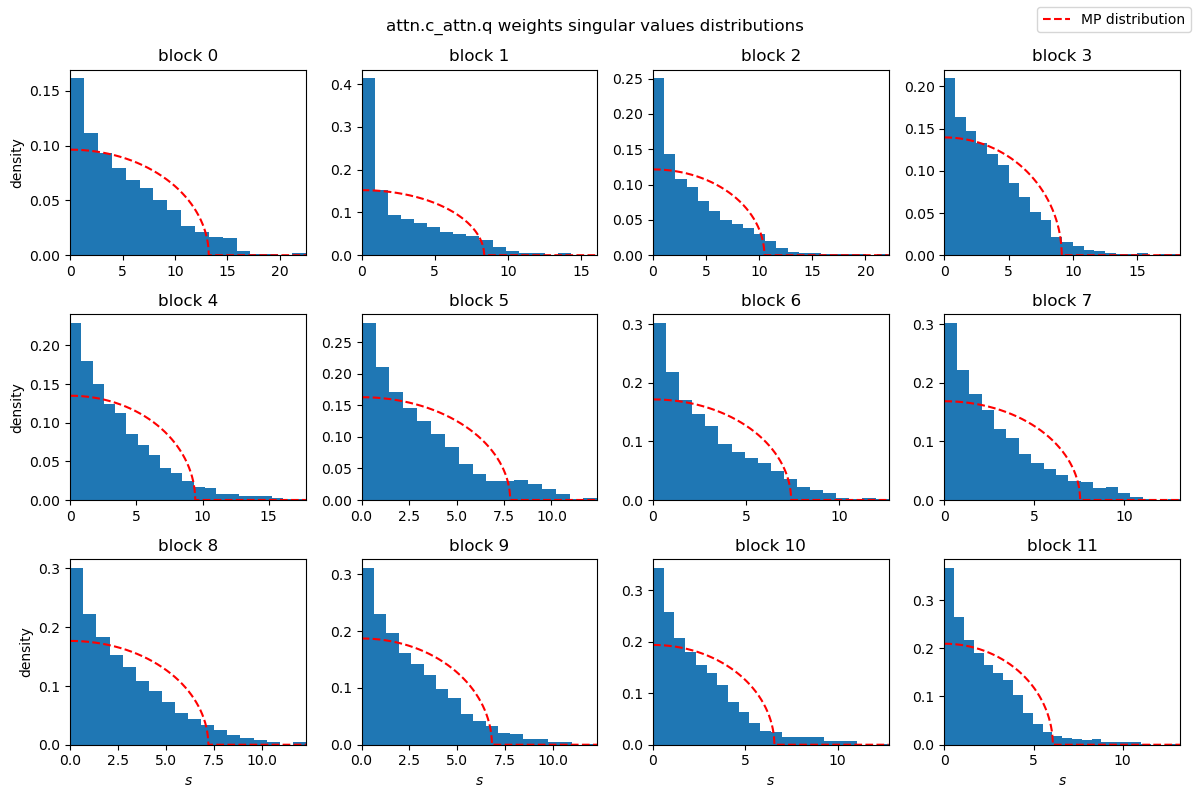

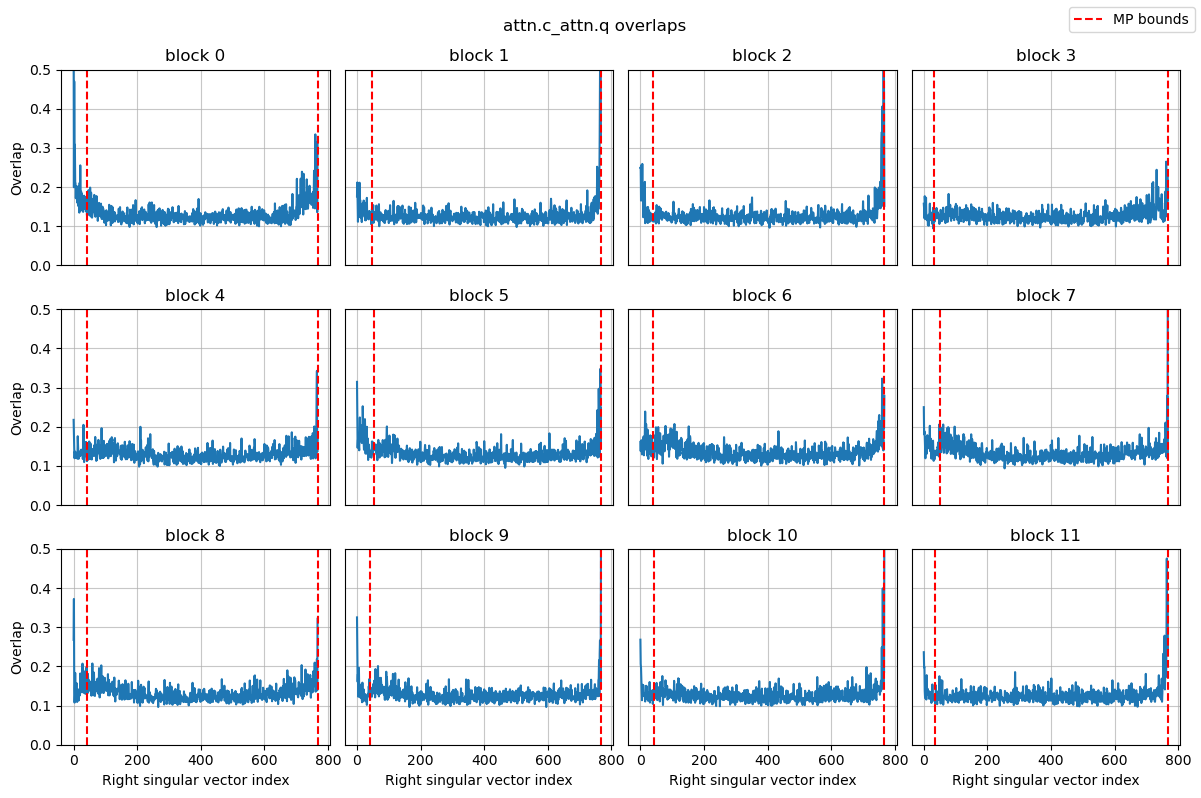

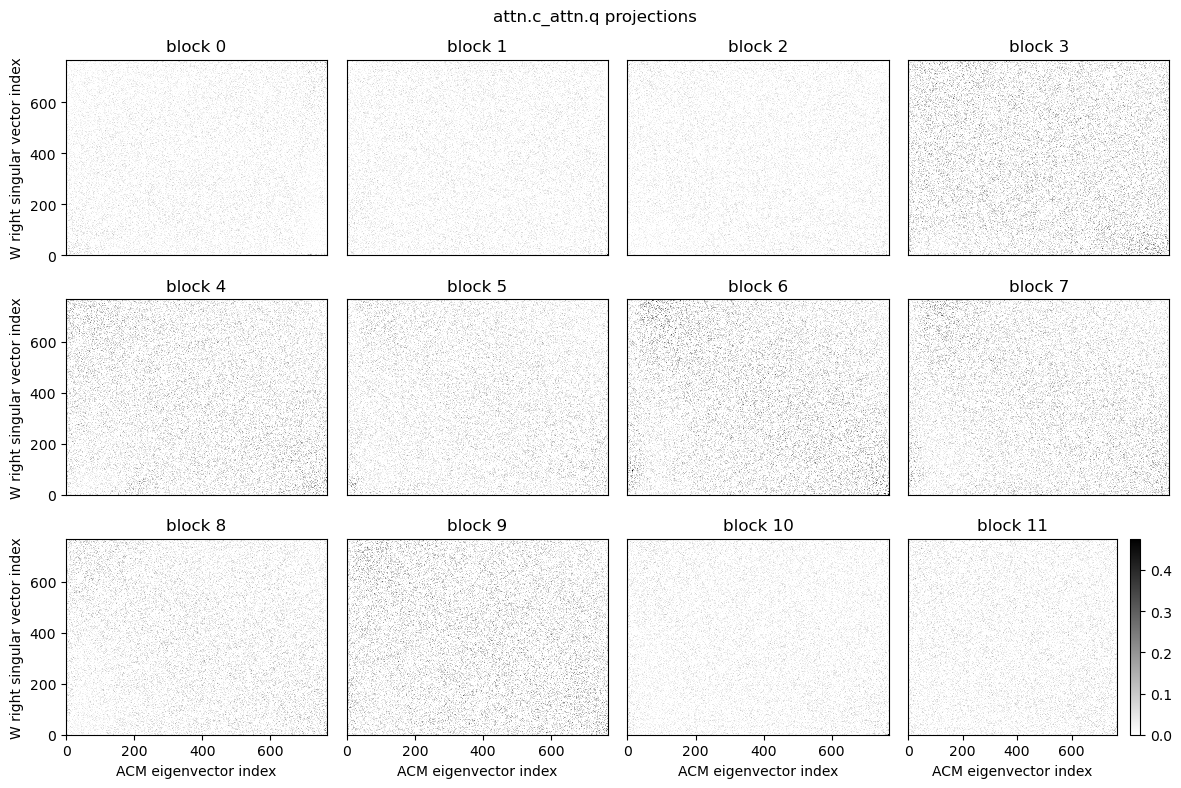

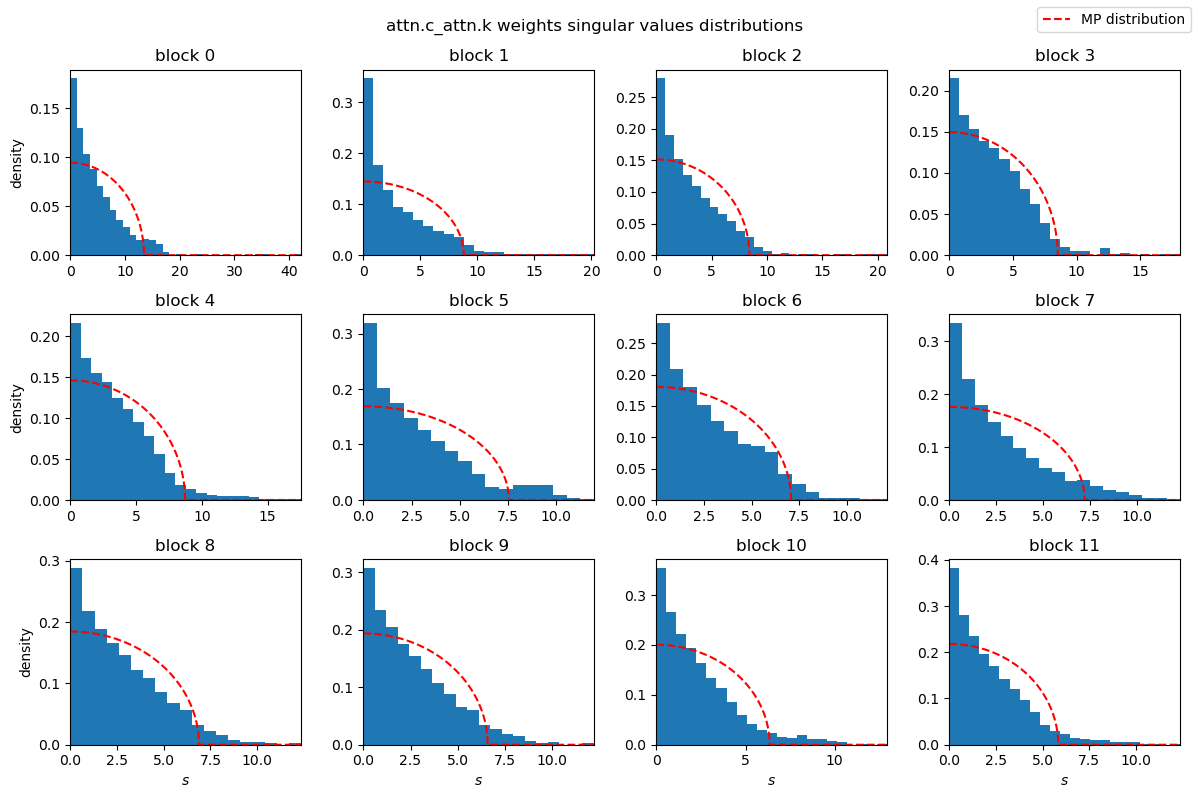

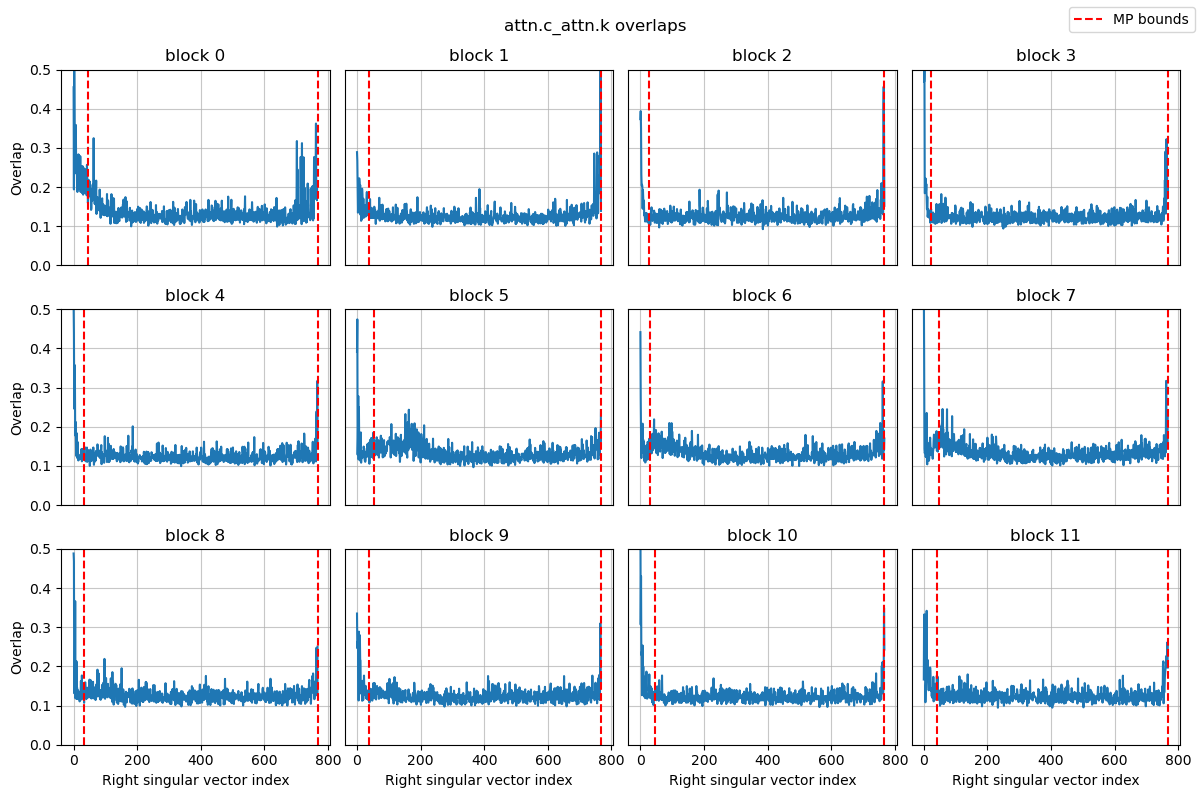

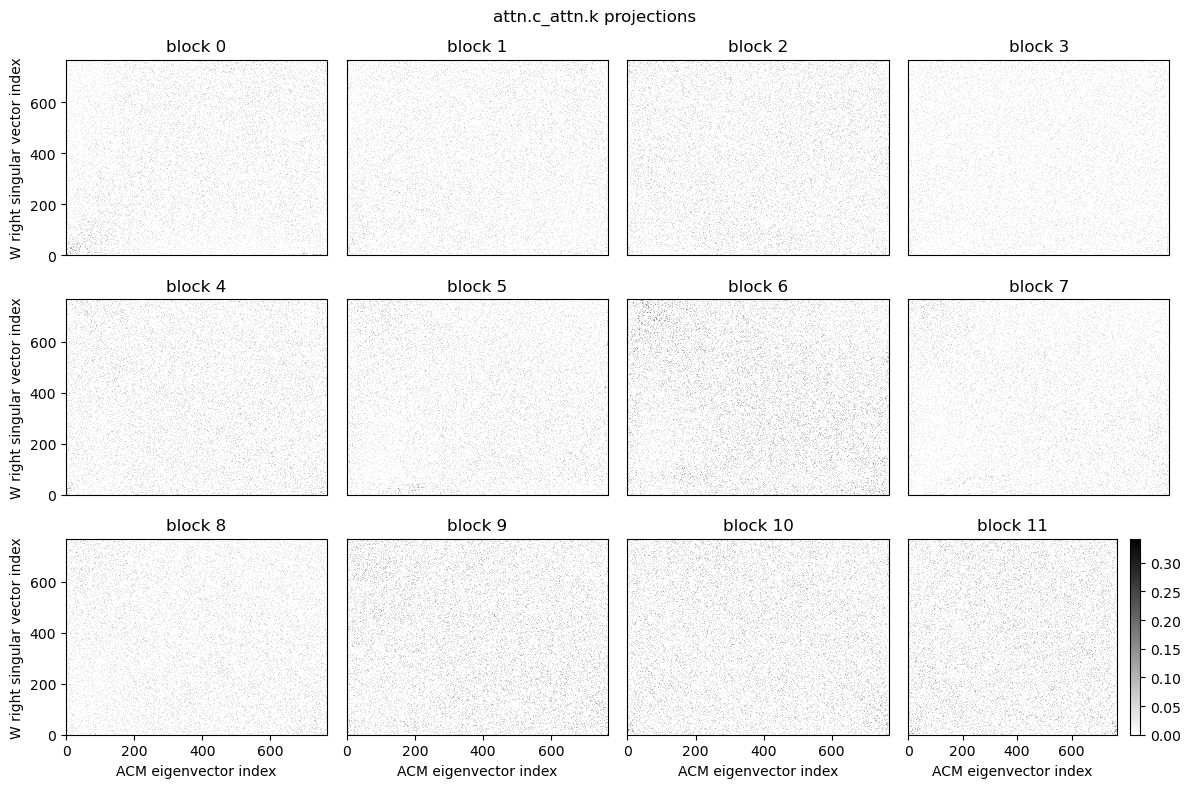

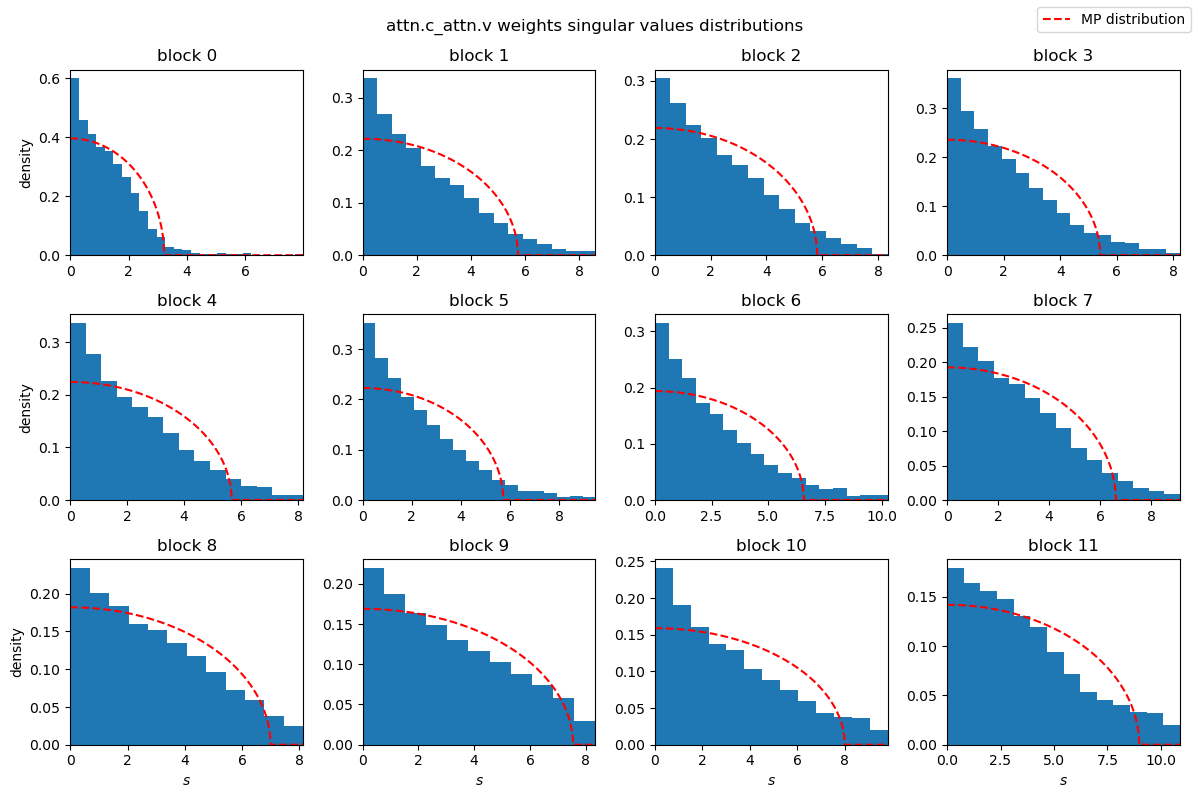

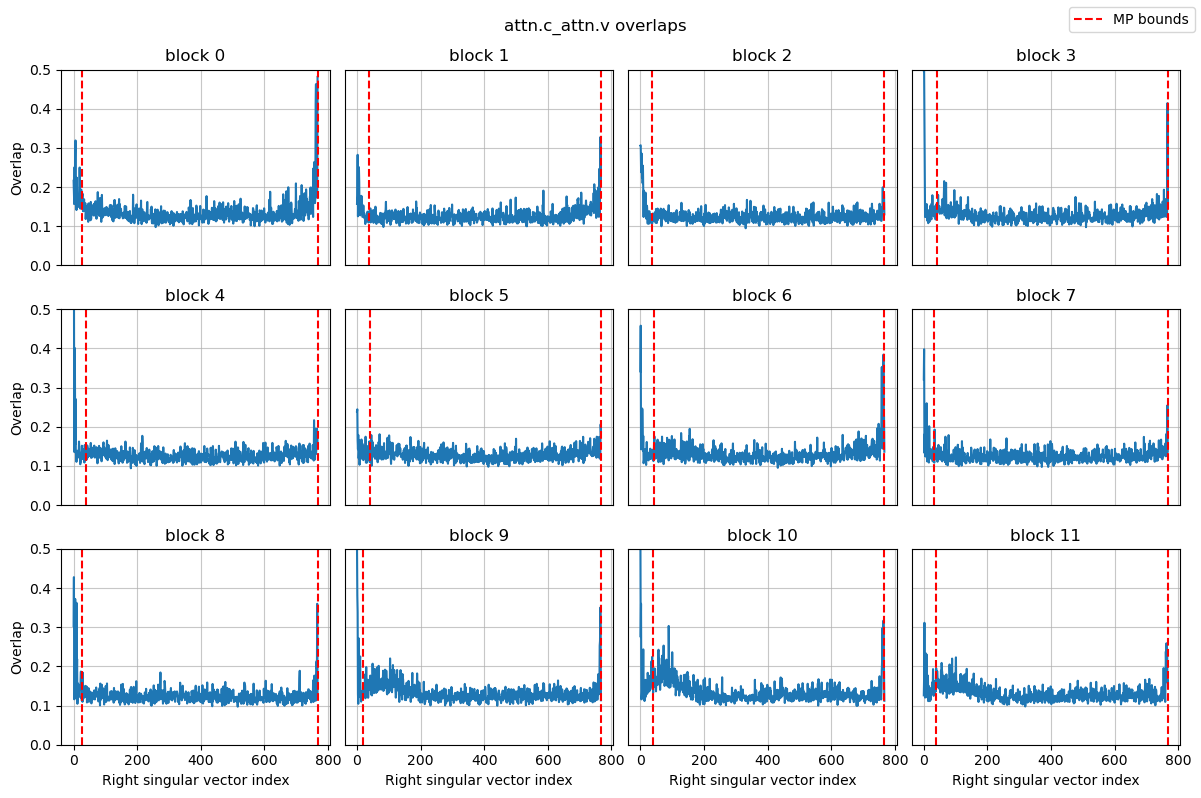

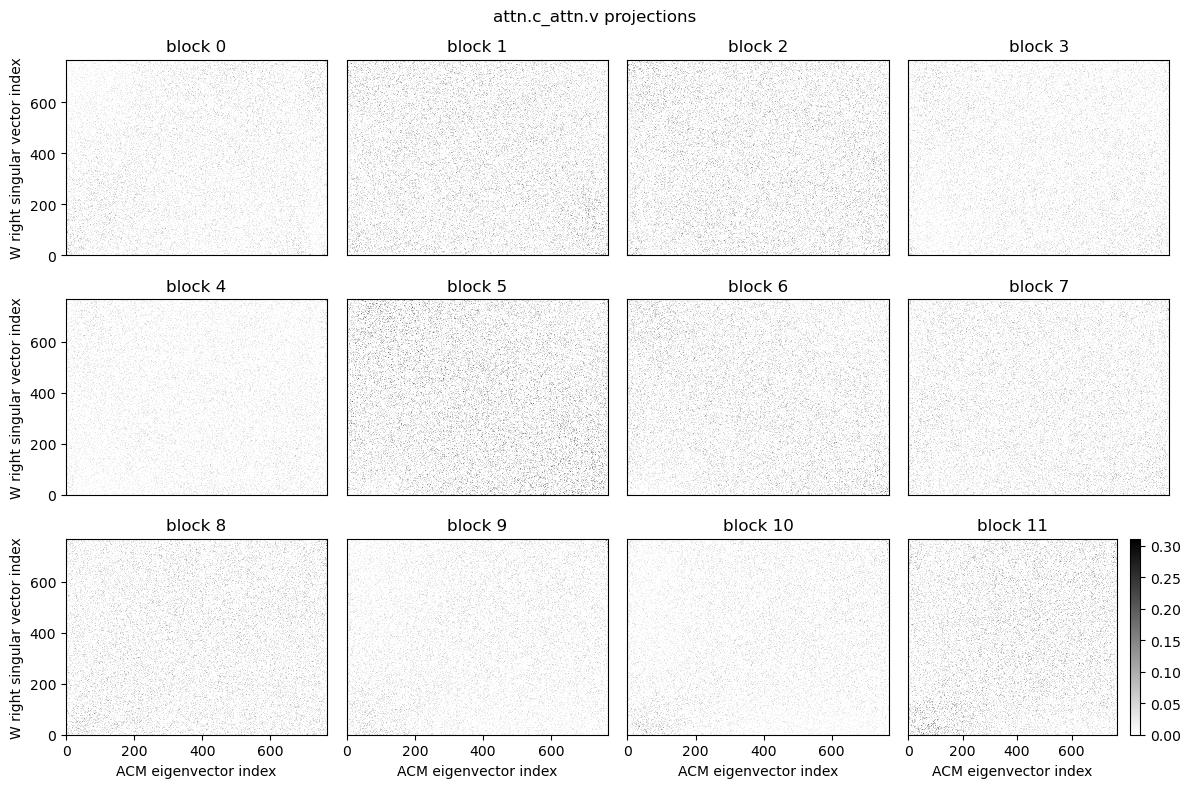

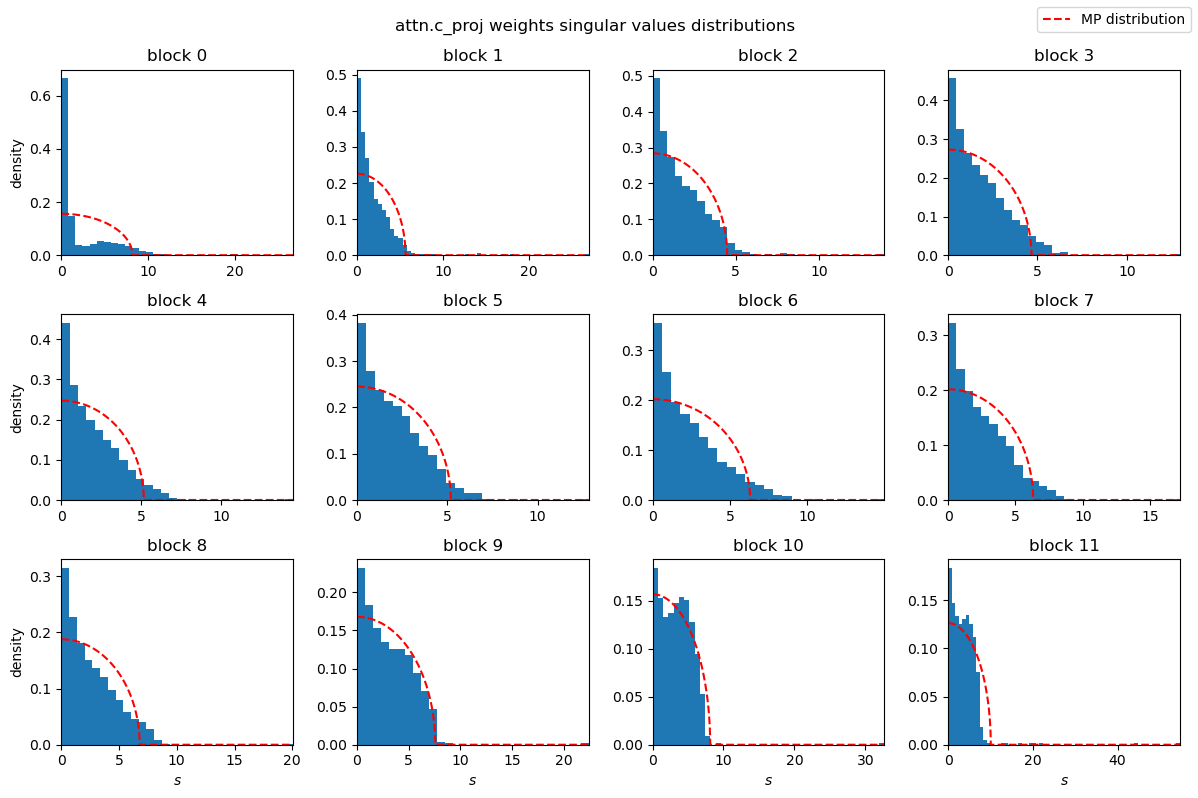

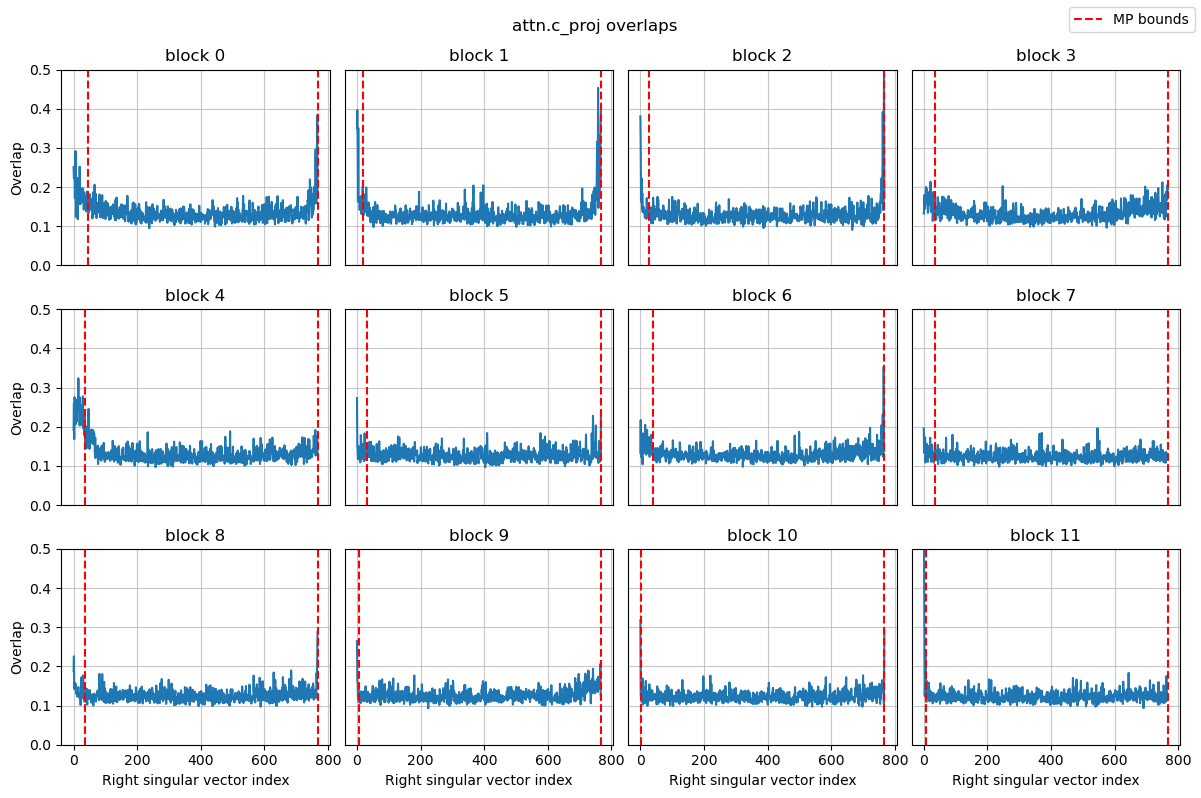

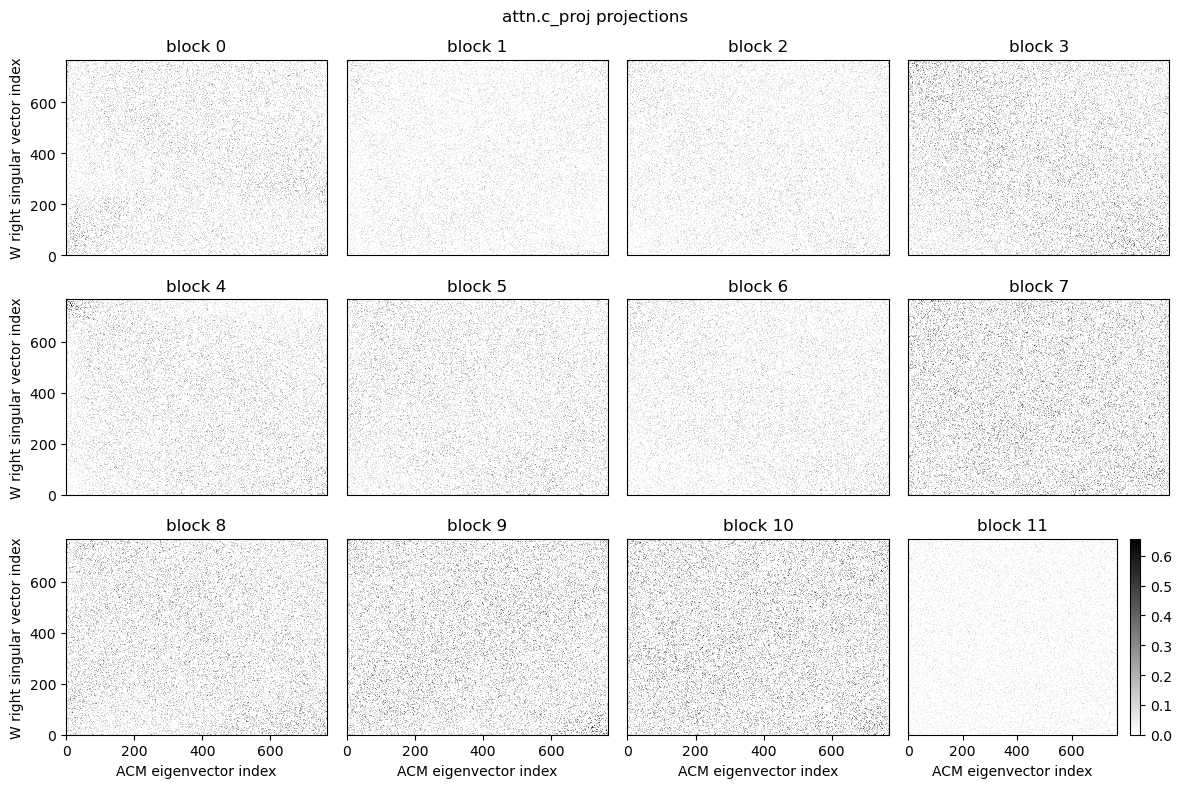

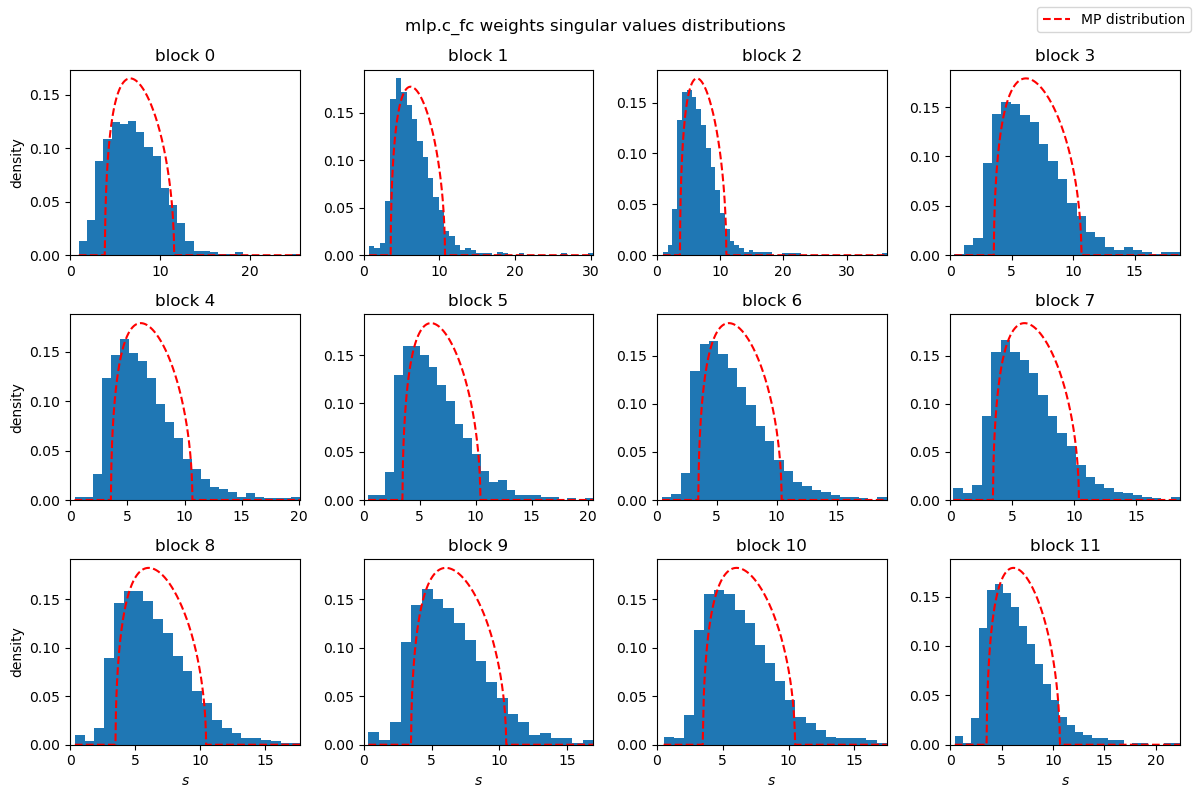

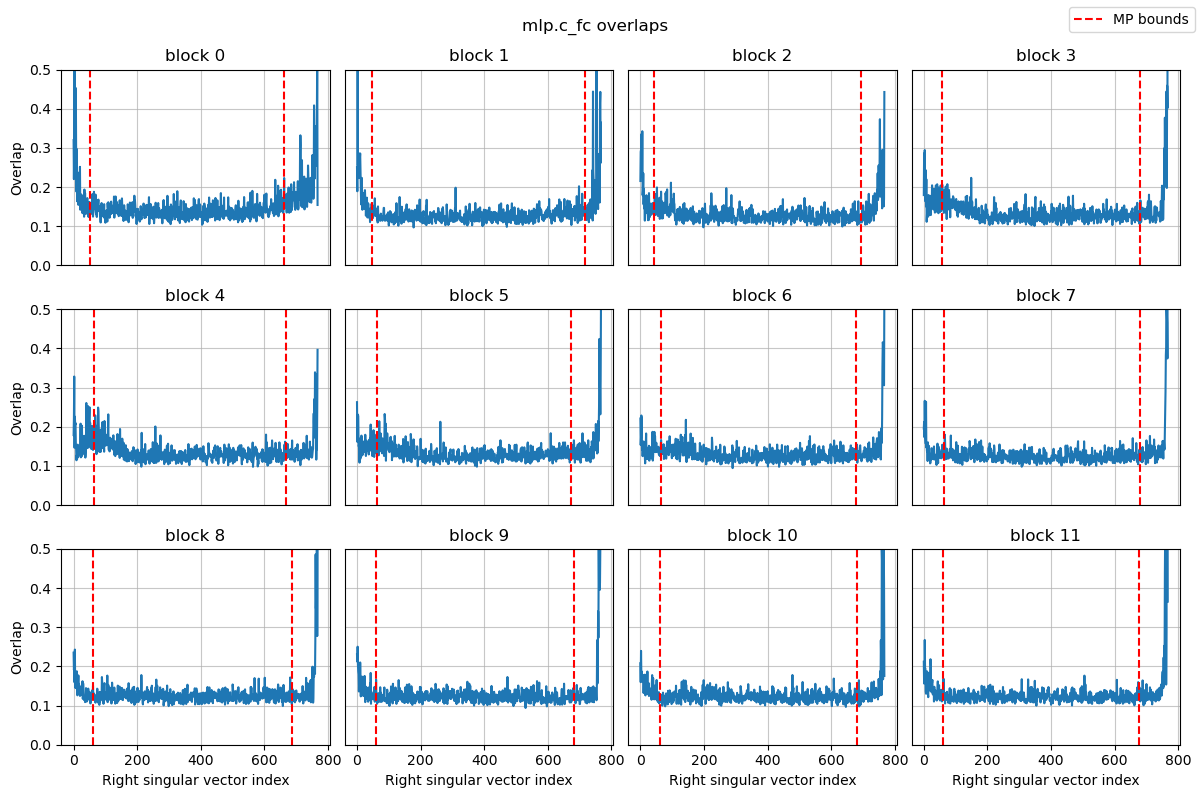

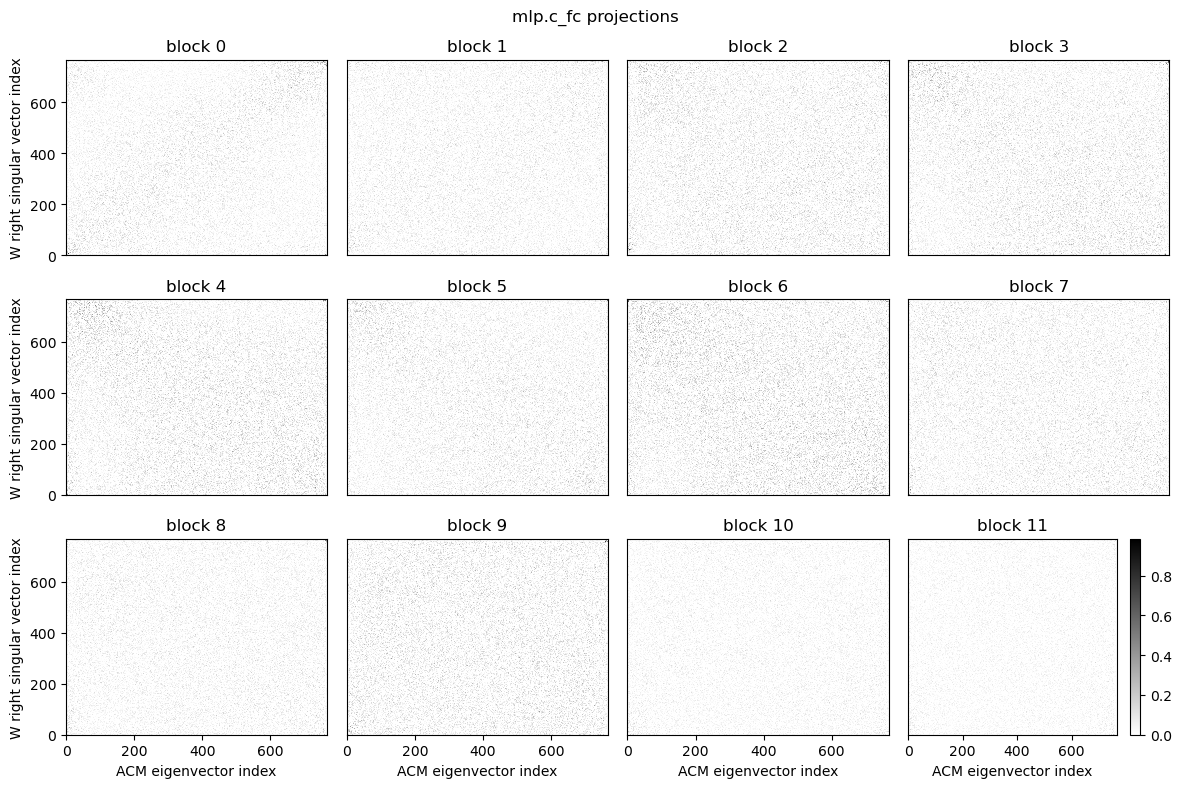

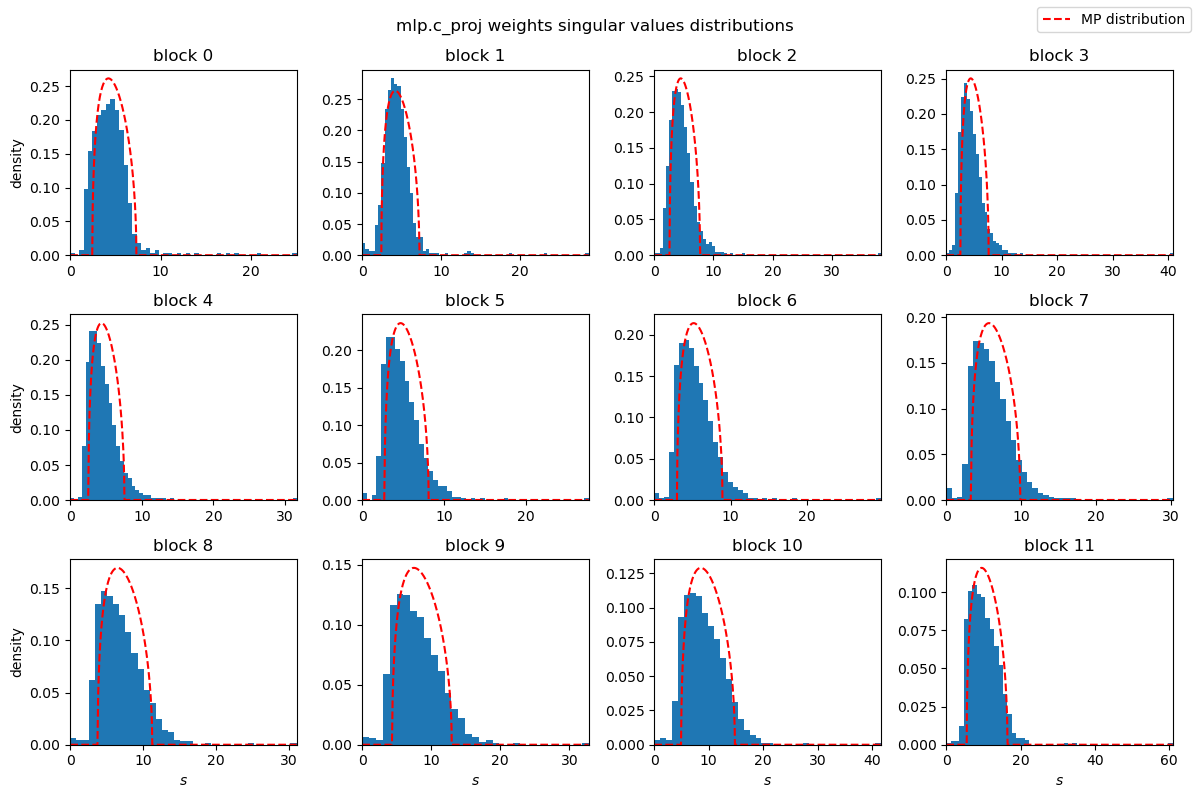

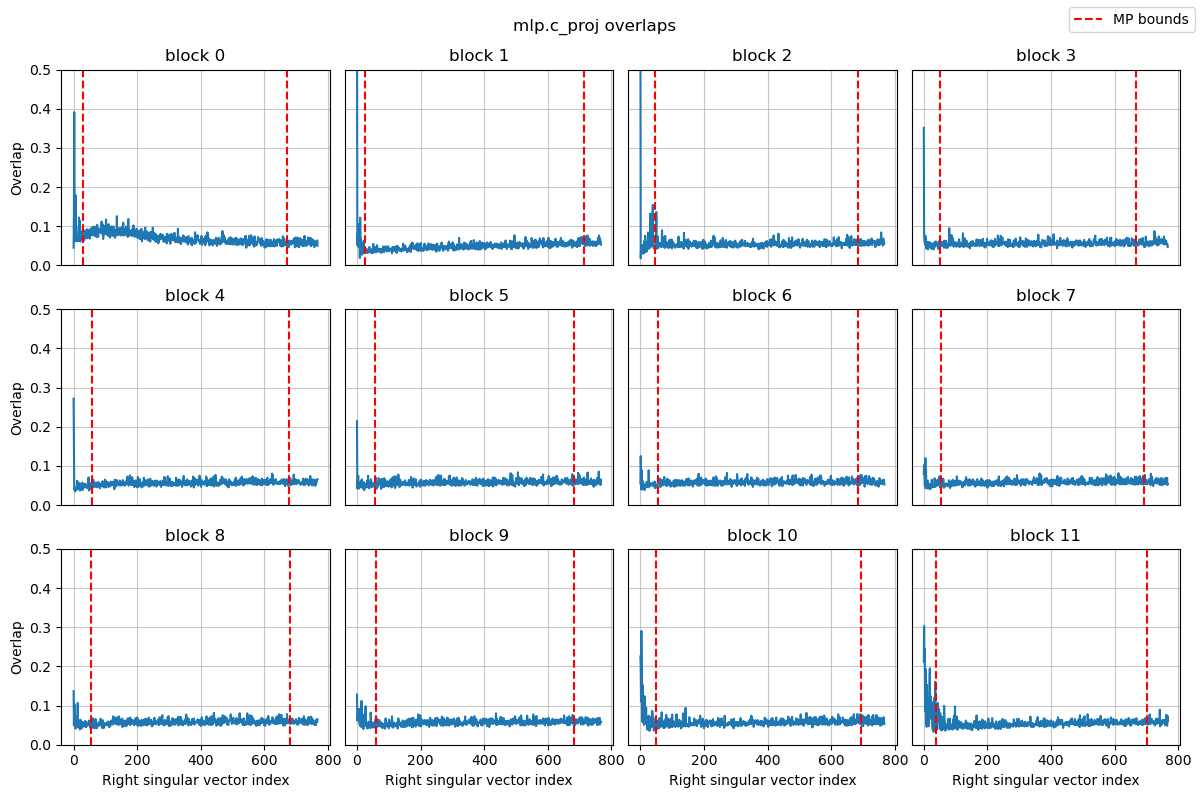

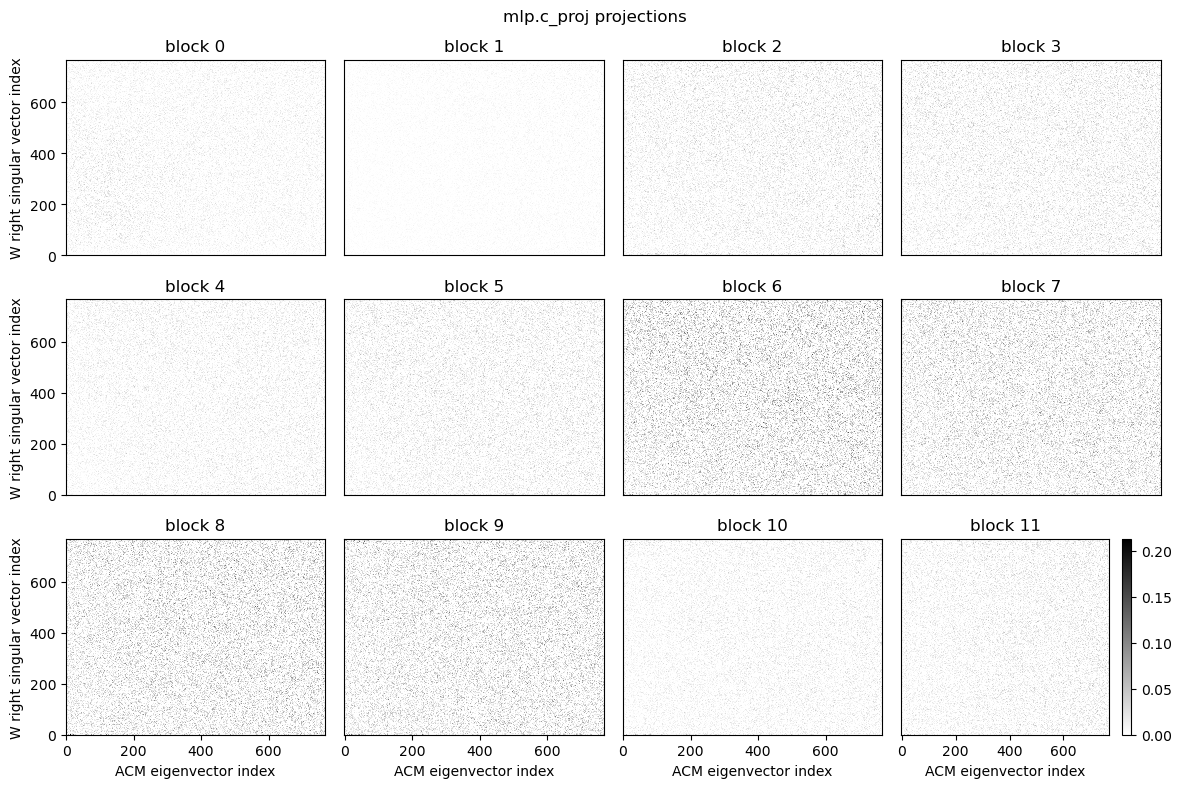

In [9]:
sublayer_selection = [
    "attn.c_attn.q",
    "attn.c_attn.k",
    "attn.c_attn.v",
    "attn.c_proj",
    "mlp.c_fc", 
    "mlp.c_proj"
]
M = [768, 768, 768, 768, 3072, 3072]
for sublayer, m in zip(sublayer_selection, M):
    plot_layer_svals(sublayer, 768, m)
    plot_layer_overlaps(sublayer, 768, m)
    plot_layer_projections(sublayer, 768, m)